In [1]:
!date

Sat Oct 24 15:53:53 PDT 2020


# Isoform atlas

In [1]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from scipy.sparse import csr_matrix, lil_matrix
from matplotlib import cm

import warnings
warnings.filterwarnings('ignore')

def nd(arr):
    return np.asarray(arr).reshape(-1)

import sys
sys.path.append('/home/sina/projects/mop/BYVSTZP_2020/trackfig')
from trackfig.utils import get_notebook_name
from trackfig.trackfig import trackfig 

TRACKFIG = "/home/sina/projects/mop/BYVSTZP_2020/trackfig.txt"
NB = get_notebook_name()

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [2]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 PT" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
}

cluster_order = [
#    "L5 IT",
    "L5/6 NP",
    "L5 PT", 
    "L2/3 IT",
    "L6b",
    "L6 IT",
    "L6 CT",
    "L6 IT Car3",
    "Lamp5",
    "Sncg",
    "Vip",
    "Sst",
    "Pvalb",
#     "VLMC",
#     "Endo",
#     "Astro",
#     "SMC"
]

In [3]:
gene = anndata.read_h5ad("../../data/notebook/revision/gene.h5ad")
isoform = anndata.read_h5ad("../../data/notebook/revision/isoform.h5ad")

In [4]:
markers = pd.concat([pd.read_csv("../../tables/unordered/subclass_DE_isoform_only-GLUT.csv", index_col=0), pd.read_csv("../../tables/unordered/subclass_DE_isoform_only-GABA.csv", index_col=0)])

In [5]:
markers["index"].value_counts()

L2/3 IT       2387
L6b           2214
Pvalb         1725
Sst           1089
L6 IT          971
L5/6 NP        866
L6 CT          833
Lamp5          661
Sncg           608
L5 PT          301
Vip            276
L6 IT Car3      16
Name: index, dtype: int64

## We remove ATP synthase isoforms as well as lincRNA , as they are not relevant to the analysis. 

In [6]:
markers = markers[np.logical_and(~markers["name"].str.contains("Atp"), ~markers["name"].str.contains("AC130815.2"))]

In [7]:
features = isoform.var.transcript_name.values

In [8]:
mtx = isoform.layers["norm"].todense()
markers["exp"] = markers.name.apply(lambda x: mtx[:,isoform.var.transcript_name==x].mean())

In [9]:
# markers.iloc[markers.groupby("index")["exp"].apply(np.argmax)]

In [10]:
def pick_top(l):
    idx = [np.where(features==i)[0][0] for i in l]

    argmax = np.argmax(nd(isoform.layers["norm"].mean(axis=0))[idx])
    return argmax

In [11]:
%%time
top = markers.groupby("index")['name'].apply(lambda x: list(x)[0:20][pick_top(list(x)[0:20])])

CPU times: user 14.1 s, sys: 8.7 s, total: 22.8 s
Wall time: 22.9 s


In [12]:
top

index
L2/3 IT        Mcts1-201_ENSMUST00000000365
L5 PT          Cox5a-201_ENSMUST00000000090
L5/6 NP       Ndufb2-202_ENSMUST00000119379
L6 CT          Calm1-203_ENSMUST00000127300
L6 IT          Calm1-202_ENSMUST00000110082
L6 IT Car3       Cck-201_ENSMUST00000035120
L6b            Cox5a-201_ENSMUST00000000090
Lamp5          Calm1-203_ENSMUST00000127300
Pvalb          Calm1-203_ENSMUST00000127300
Sncg            Pld3-201_ENSMUST00000117095
Sst            Calm1-202_ENSMUST00000110082
Vip              Ubb-201_ENSMUST00000019649
Name: name, dtype: object

In [13]:
#top = top.drop("Low Quality")
top = top[cluster_order]
top_idx = [np.where(isoform.var.transcript_name == i)[0][0] for i in top]
top_name = ["".join(i.split("_")[:-1]) for i in top]

In [14]:
top

index
L5/6 NP       Ndufb2-202_ENSMUST00000119379
L5 PT          Cox5a-201_ENSMUST00000000090
L2/3 IT        Mcts1-201_ENSMUST00000000365
L6b            Cox5a-201_ENSMUST00000000090
L6 IT          Calm1-202_ENSMUST00000110082
L6 CT          Calm1-203_ENSMUST00000127300
L6 IT Car3       Cck-201_ENSMUST00000035120
Lamp5          Calm1-203_ENSMUST00000127300
Sncg            Pld3-201_ENSMUST00000117095
Vip              Ubb-201_ENSMUST00000019649
Sst            Calm1-202_ENSMUST00000110082
Pvalb          Calm1-203_ENSMUST00000127300
Name: name, dtype: object

In [15]:
mat = isoform.layers["norm"].todense()
obs = isoform.obs
var = isoform.var

In [16]:
markers[markers.name.str.contains("Car")]

,index,name,p_raw,p_corr,es,exp
464,L2/3 IT,Car4-201_ENSMUST00000103194,1.924734e-217,1.200842e-213,3.678958,82.342521
2189,L2/3 IT,Car11-201_ENSMUST00000003360,3.054226e-38,1.905531e-34,0.399049,85.043512
2190,L2/3 IT,Car11-204_ENSMUST00000210872,2.472503e-31,1.542594e-27,0.679498,15.256051
55186,L2/3 IT,Car10-201_ENSMUST00000042943,3.803291e-50,2.372873e-46,1.046772,26.336300
259741,L6 CT,Carmil2-201_ENSMUST00000062574,1.651217e-34,7.825120e-31,0.330875,23.142294
331874,L6 IT,Car10-201_ENSMUST00000042943,1.147792e-20,6.510274e-17,0.712930,26.336300
2189,Lamp5,Car11-201_ENSMUST00000003360,4.774500e-09,1.381740e-05,0.425246,85.043512
89696,Pvalb,Carf-210_ENSMUST00000191232,3.629378e-07,1.182451e-03,0.183213,2.857920
209705,Sst,Car11-201_ENSMUST00000003360,1.058076e-08,3.249352e-05,0.379337,85.043512
259741,Sst,Carmil2-201_ENSMUST00000062574,9.213744e-16,2.829541e-12,0.470139,23.142294


In [17]:
marker_map = {
    #"L5 IT": "Dkkl1-201_ENSMUST00000033057",
"L5/6 NP": "Il11ra1-204_ENSMUST00000108042",
"L5 PT": "S100b-201_ENSMUST00000036387",
"L2/3 IT": "Calb1-201_ENSMUST00000029876",    
"L6b": "Glra2-201_ENSMUST00000058787",
"L6 IT": "Cdh9-202_ENSMUST00000228307",
"L6 CT": "Cpa6-203_ENSMUST00000147575",
"L6 IT Car3": "Cpne4-204_ENSMUST00000157006",
"Lamp5": "Lamp5-202_ENSMUST00000123436",
"Sncg": "Cnr1-202_ENSMUST00000084736",
"Vip": "Vip-201_ENSMUST00000019906",
"Sst": "Sst-201_ENSMUST00000004480",
"Pvalb": "Pvalb-201_ENSMUST00000005860",
# "VLMC": "Myl12a-201_ENSMUST00000024846",
# "Endo": "Pglyrp1-201_ENSMUST00000032573",
# "Astro": "Mc1r-201_ENSMUST00000098324",
# "SMC":  "Myl9-201_ENSMUST00000088552"
             }

In [18]:
top_idx = [np.where(isoform.var.transcript_name == i)[0][0] for i in list(marker_map.values())]
top_name = ["".join(i.split("_")[:-1]) for i in list(marker_map.values())]

In [19]:
top

index
L5/6 NP       Ndufb2-202_ENSMUST00000119379
L5 PT          Cox5a-201_ENSMUST00000000090
L2/3 IT        Mcts1-201_ENSMUST00000000365
L6b            Cox5a-201_ENSMUST00000000090
L6 IT          Calm1-202_ENSMUST00000110082
L6 CT          Calm1-203_ENSMUST00000127300
L6 IT Car3       Cck-201_ENSMUST00000035120
Lamp5          Calm1-203_ENSMUST00000127300
Sncg            Pld3-201_ENSMUST00000117095
Vip              Ubb-201_ENSMUST00000019649
Sst            Calm1-202_ENSMUST00000110082
Pvalb          Calm1-203_ENSMUST00000127300
Name: name, dtype: object

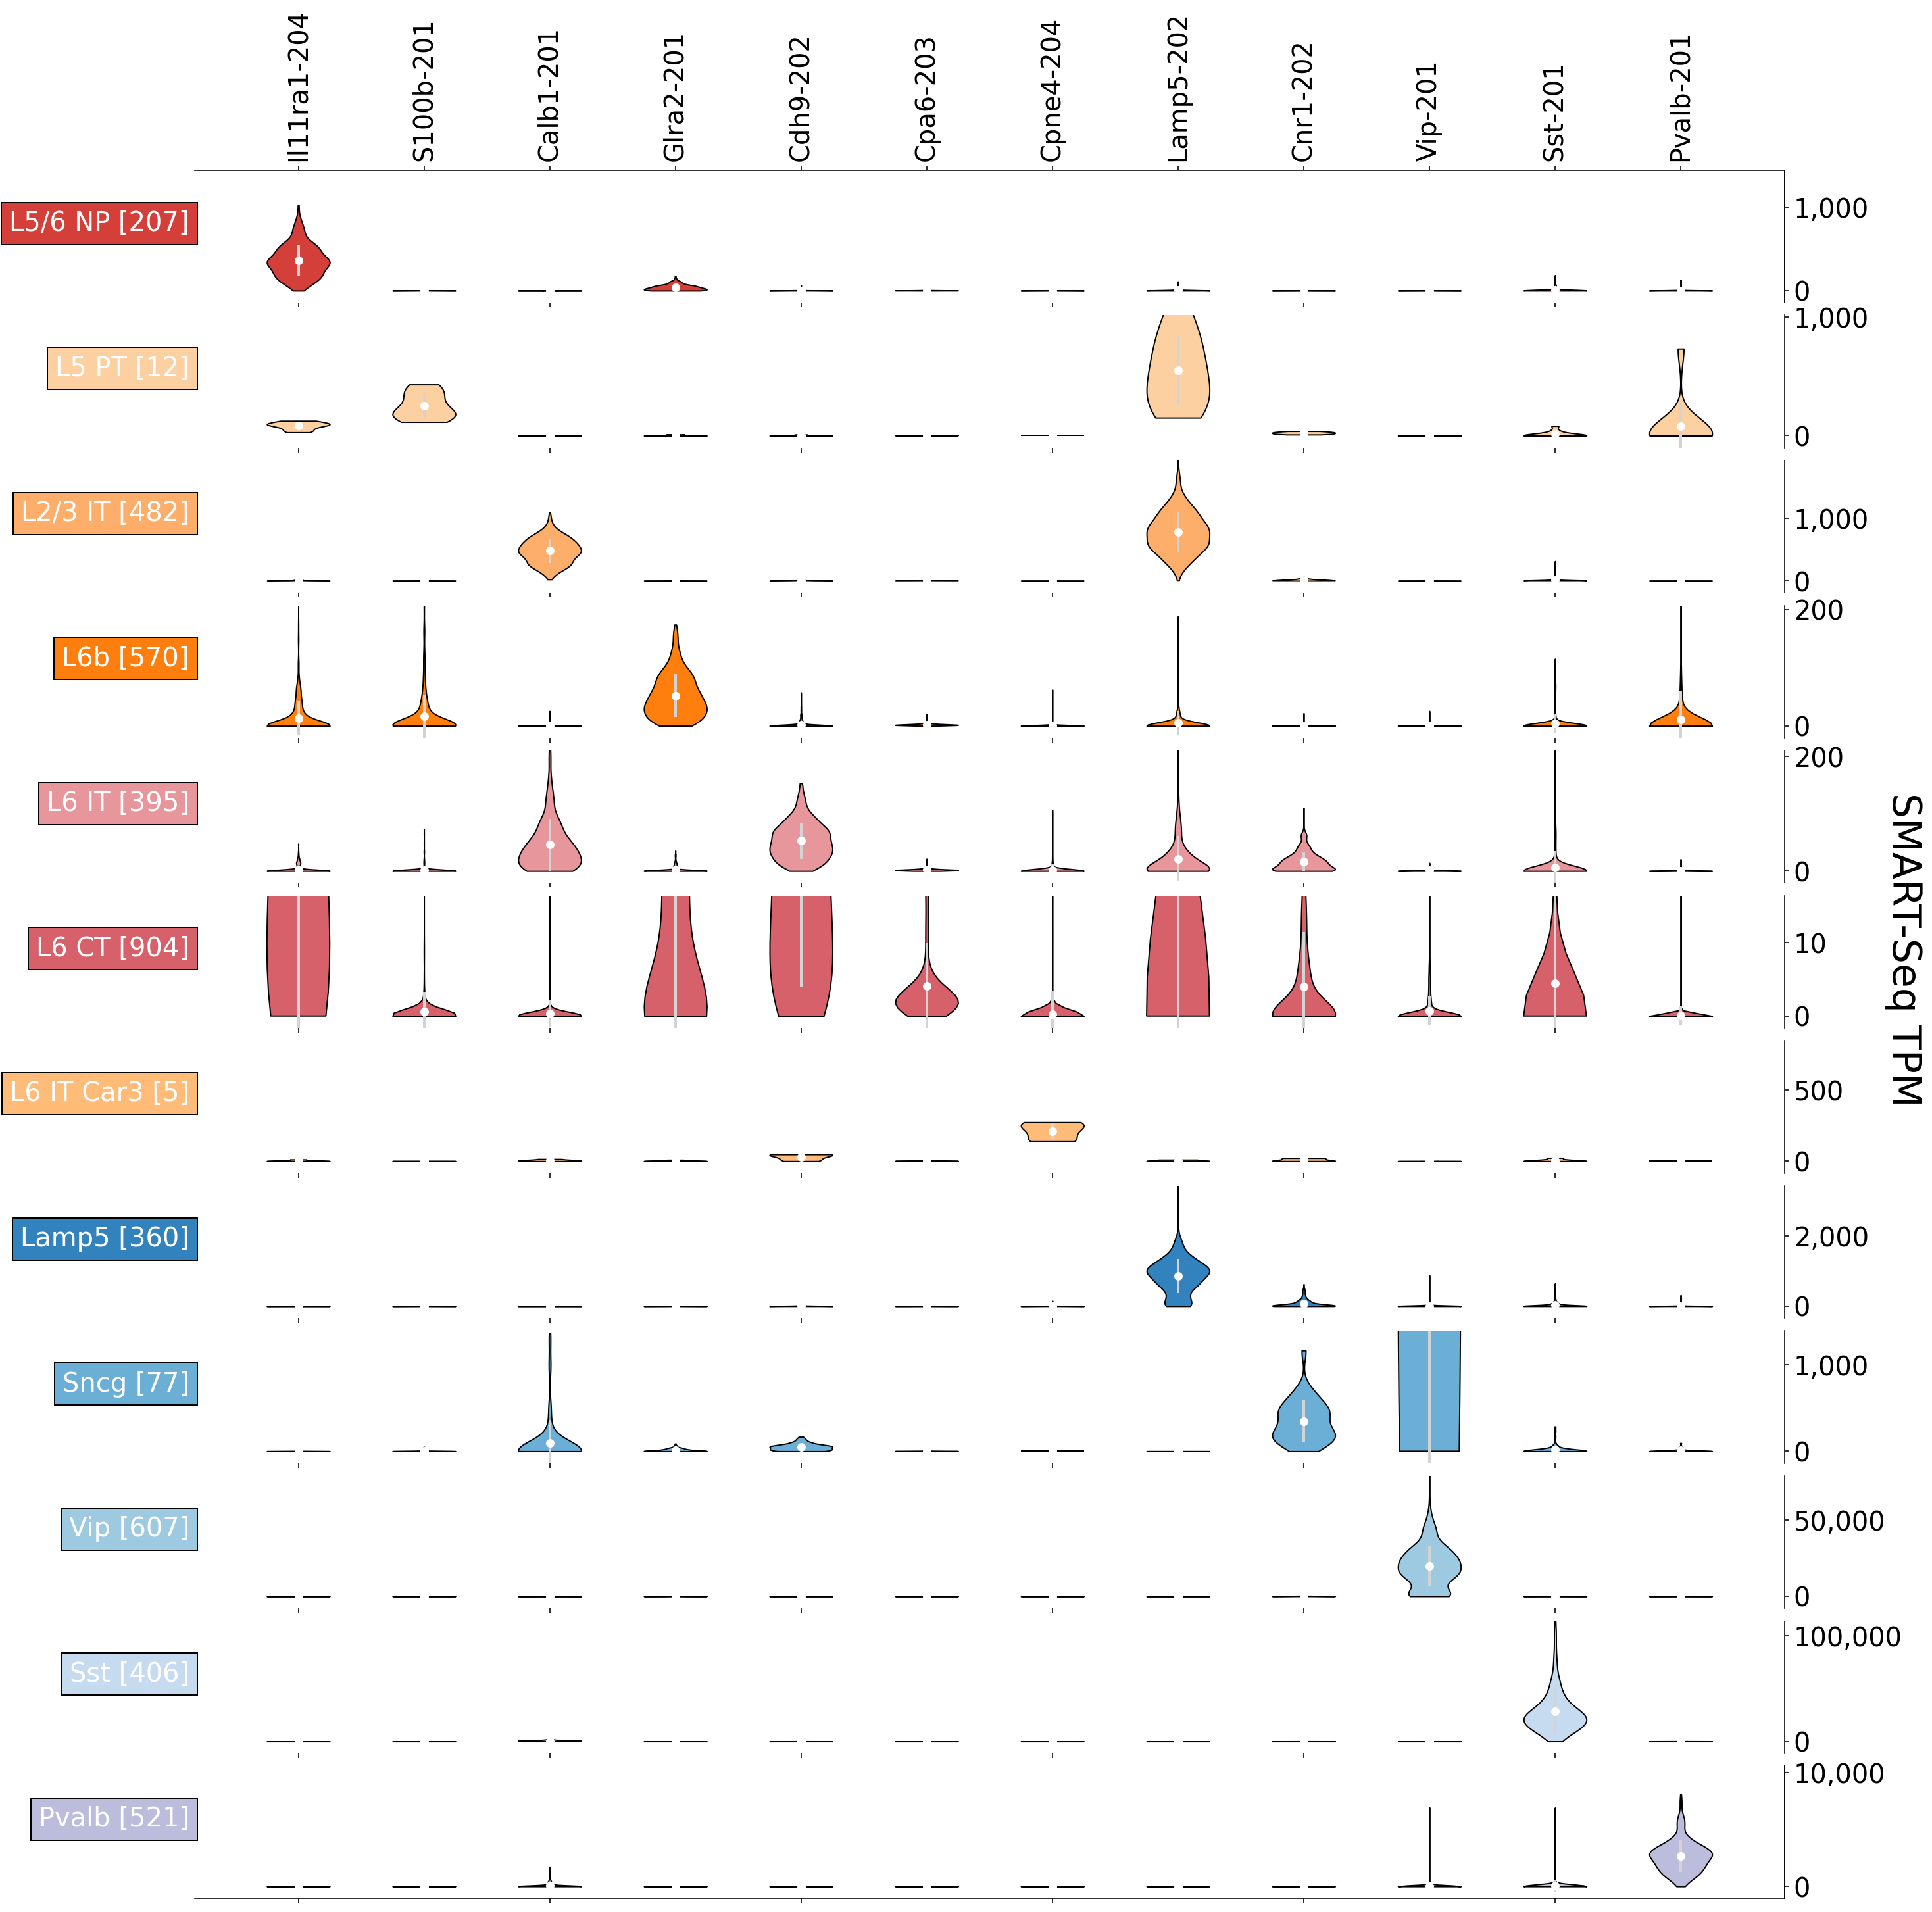

In [21]:
# unique = np.unique(gene.obs.subclass_label)
# unique = np.delete(unique, np.where(unique=="Low Quality"))
unique = np.array(cluster_order)

fig, axs = plt.subplots(figsize=(20,20), nrows=len(unique))
fig.subplots_adjust(wspace=0, hspace=0)


labels = top_name
lidx = np.arange(0, len(top_idx), 1)
means = []

for cidx, (c, ax) in enumerate(zip(unique, axs)):
    tmp_mat = mat[obs.subclass_label==c,:]
    
    x = tmp_mat[:,top_idx]
    means.append(nd(np.median(x,axis=0)))

    v = ax.violinplot(x.T.tolist(), showmedians=False, showextrema=False, positions=lidx)

    for pcidx, pc in enumerate(v['bodies']):
        pc.set_facecolor(cluster_cmap[c])
        pc.set_edgecolor('black')
        pc.set_alpha(1)
        #pc.set_facecolor('#D43F3A')
        

    means = [np.mean(i) for i in x.T]
    stdevs = np.array([np.sqrt(np.var(i)) for i in x.T])
    ax.vlines(lidx, nd(means) - stdevs, nd(means)+stdevs, color='lightgrey', linestyle='-', lw=2, zorder=9)
    ax.scatter(lidx, means, marker='o', color='white', s=30, zorder=10)
 
    if cidx==0:
        ax_top = ax.twiny()
        ax_top.set_xlim(ax.get_xlim())
        ax_top.set_xticks(lidx)
        ax_top.set_xticklabels(labels, rotation=90, ha="center")
        ax_top.spines["top"].set_visible(True)
        ax_top.spines["left"].set_visible(False)
        ax_top.spines["bottom"].set_visible(False)
    if cidx == len(unique)-1:
        ax_bot = ax.twiny()
        ax_bot.set_xticks([])
        ax_bot.set_xticklabels([])
        ax_bot.spines["top"].set_visible(False)
        ax_bot.spines["left"].set_visible(False)
        ax_bot.spines["bottom"].set_visible(True)

    ax.set_xticklabels("")
    ax.yaxis.tick_right()
    ax.set_ylabel("{} [{:,}]".format(c, x.shape[0]), color="white",rotation="horizontal", ha="right",bbox=dict(boxstyle="square",ec="black",fc=cluster_cmap[c]))
    

    
    lim = nd(x.mean(axis=0))[cidx]*4
    
    ax.set_ylim(-lim*0.1, lim)
    
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)

        
    
    

plt.tight_layout(pad=0, w_pad=0, h_pad=0)
fig.text(1, 0.5, 'SMART-Seq TPM ', ha='center', va='center', rotation=270, fontsize=30)
plt.savefig(trackfig("../../figures/isoform_atlas_violin.png", TRACKFIG, NB), bbox_inches='tight', dpi=300)
plt.show()

# Heatplot

In [30]:
unique = np.array(cluster_order)

labels = top_name
lidx = np.arange(0, len(top_idx), 1)
means = np.zeros((len(unique), len(top_idx)))

for cidx, c in enumerate(unique):
    tmp_mat = mat[obs.subclass_label==c,:]
    
    x = tmp_mat[:,top_idx]
    m = nd(np.mean(x,axis=0))
    means[cidx,:]= m/m.sum()

In [31]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

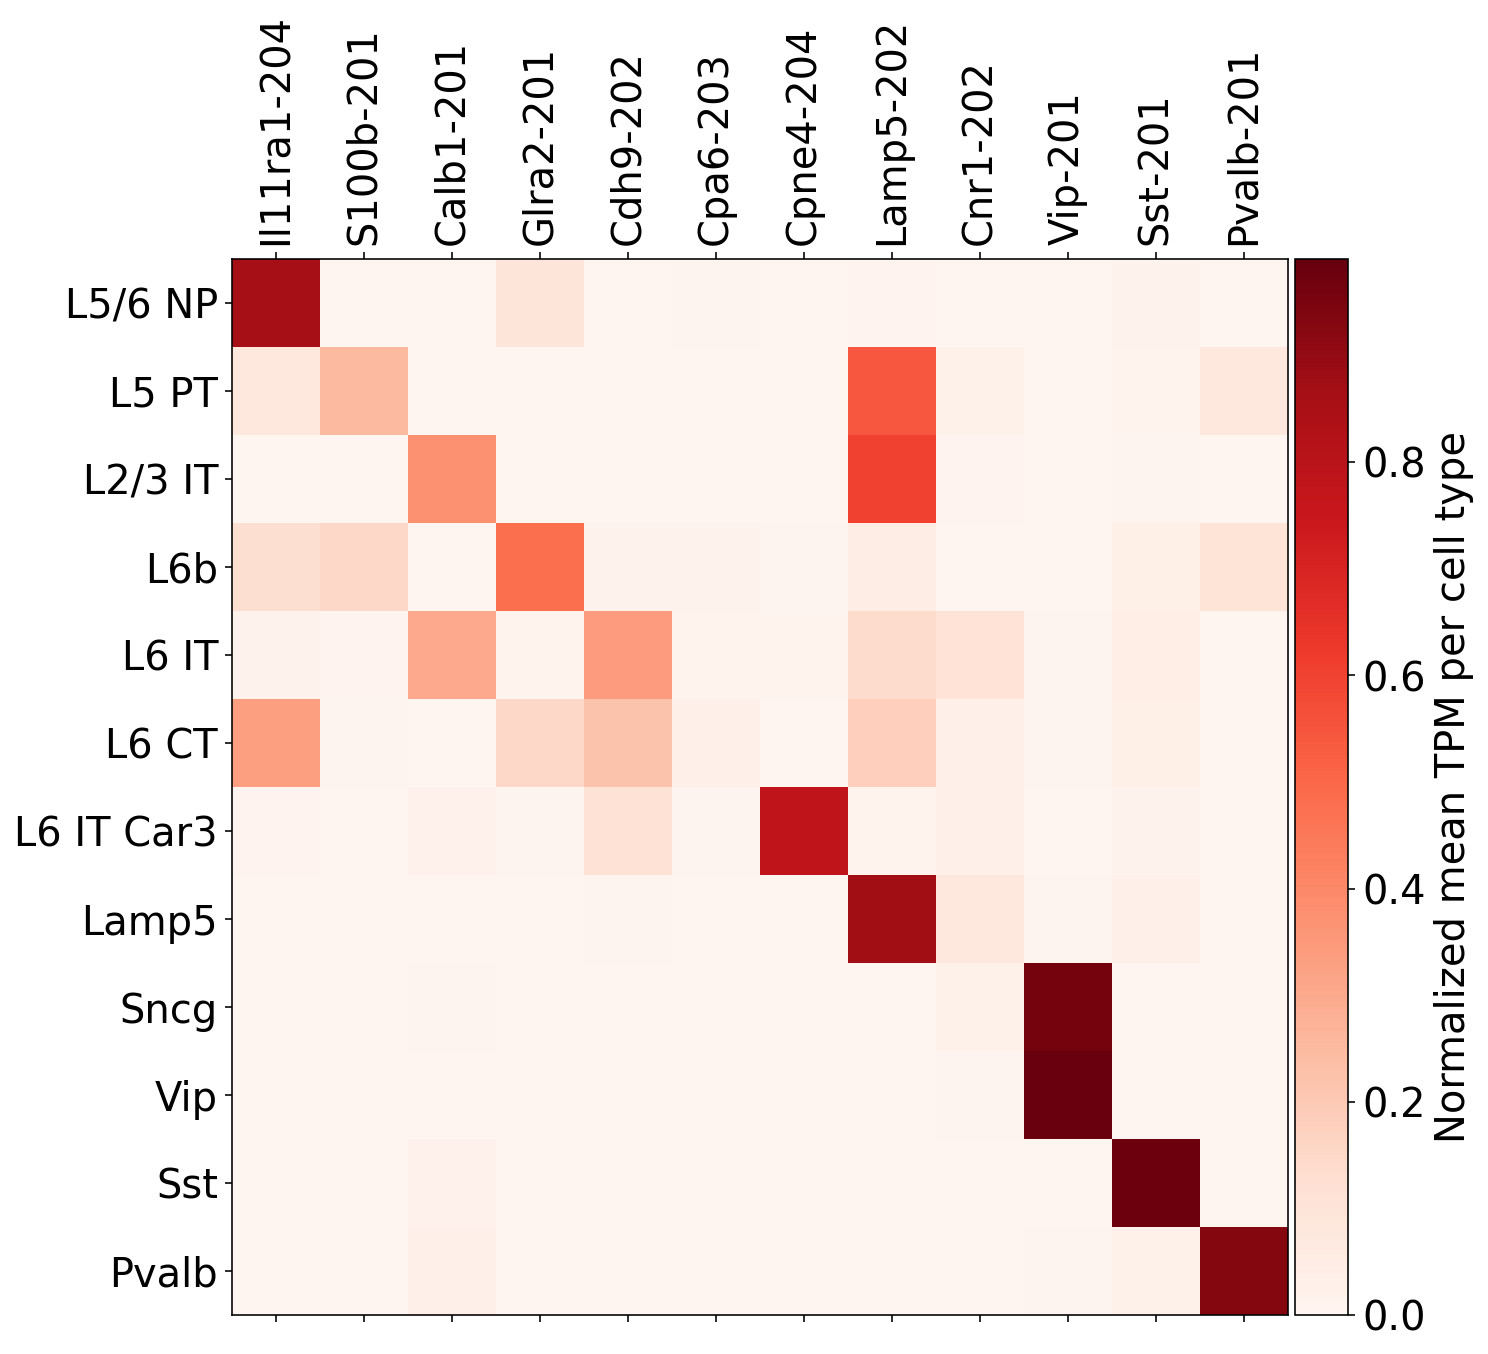

In [32]:
fig, ax = plt.subplots(figsize=(10,10))

ms = ax.matshow(means, cmap="Reds")

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(ms, cax=cax, label="Normalized mean TPM per cell type", orientation="vertical")

ax.set_xticks(lidx)
ax.set_xticklabels(labels, rotation=90, ha="center")
ax.set_yticks(range(len(unique)))
ax.set_yticklabels(unique)

plt.savefig(trackfig("../../figures/isoform_atlas_heatmap.png", TRACKFIG, NB), bbox_inches='tight', dpi=300)

fig.show()